# Automated multiband forced photometry on large datasets

### Summary:
This code performs photometry in an automated fashion at all locations in an input catalog on 4 bands of IRAC data from IRSA and 2 bands of Galex data from MAST.  The resulting catalog is then cross-matched with a Chandra catalog from HEASARC to generate a multiband catalog to facilitate galaxy evolution studies.

The code will run on 2 different science platforms and makes full use of multiple processors to optimize run time on large datasets.

### Input:
- RA and DEC within COSMOS catalog
- desired catalog radius in arcminutes
- mosaics of that region for IRAC and Galex

### Output:
- merged, multiband, science ready pandas dataframe
- IRAC color color plot for identifying interesting populations

### Authors:
Jessica Krick  
David Shupe  
Marziye JafariYazani  
Brigitta Sipocz  
Vandana Desai  
Steve Groom  

### Acknowledgements:
Nyland et al. 2017 for the workflow of the code  
Lang et al. ??? for the Tractor  
Salvato et al. 2018 for nway  
Laigle et al. 2016 for COSMOS2015  
IRSA, MAST, HEASARC  





In [1]:
import math
import time
import warnings
import concurrent.futures
import sys
import os
from contextlib import contextmanager
import numpy as np
import matplotlib.pyplot as plt
from skimage.transform import rotate

from tractor import (Tractor, PointSource, PixPos, Flux, PixelizedPSF, NullWCS,
                     NullPhotoCal, ConstantSky, Image)

### codes that may or may not already be installed in the platform
try:
    import pandas as pd
except ImportError:
    !{sys.executable} -m pip install -U pandas[all]
import pandas as pd


try:
    import seaborn as sns
except ImportError:
    !{sys.executable} -m pip install -U seaborn[all]
import seaborn as sns

try: 
    import statsmodels
except ImportError:
    !{sys.executable} -m pip install -U statsmodels[all]
import statsmodels

try: 
    import mpld3
except ImportError:
    !{sys.executable} -m pip install -U mpld3[all]
import mpld3
from mpld3 import plugins, utils

try: 
    import boto3
except ImportError:
    !{sys.executable} -m pip install -U boto3[all]
import boto3

from firefly_client import FireflyClient
import firefly_client.plot as ffplt

from astropy.nddata import Cutout2D
from astropy.stats import sigma_clipped_stats
import astropy.wcs as wcs
import astropy.io.fits as fits
from astropy.table import Table
from astropy.coordinates import SkyCoord
import astropy.units as u

from astroquery.ipac.irsa import Irsa
from astroquery.heasarc import Heasarc
from astroquery.mast import Observations

###nway
try:
    import nwaylib.fastskymatch as fastskymatch
except ImportError:
    !{sys.executable} -m pip install -U nway[all]


import nwaylib.fastskymatch as fastskymatch
import nwaylib.bayesdistance as bayesdistance
import nwaylib.checkupdates as checkupdates
import nwaylib.magnitudeweights as magnitudeweights
import nwaylib.progress as nwayprogress


### supporting functions
sys.path.append('../code/')
from determine_source_type import determine_source_type
from extract_cutout import extract_cutout
from find_nconfsources import find_nconfsources
from display_images import display_images
from plot_SED import plot_SED
from nway_write_header import nway_write_header
#from prepare_prf import prepare_prf

%matplotlib inline

In [2]:
sys.version

'3.8.6 | packaged by conda-forge | (default, Oct  7 2020, 19:08:05) \n[GCC 7.5.0]'

### Pull initial catalog from IRSA
- Automatically set up a catalog with ra, dec, photometric redshifts, fiducial band fluxes, & probability that it is a star  
- Catalog we are using is COSMOS2015 (Laigle et al. 2016)  
- Data exploration

In [3]:
#pull a COSMOS catalog from IRSA using astroquery

#make sure the archive isn't limiting our search
#default values of row_limit are often much lower than what we might want 
Irsa.ROW_LIMIT = 3E6  
Irsa.TIMEOUT = 600


#what is the central RA and DEC of the desired catalog
coords = SkyCoord('150.01d 2.2d', frame='icrs')  #COSMOS center acording to Simbad

#how large is the search radius
rad_in_arcmin = 3  #full COSMOS is 48arcmin  #was testing with smaller like 3 or 15

#use Astroquery to get the catalog
#specify only select columns to limit the size of the catalog
cosmos_table = Irsa.query_region(coords, catalog = "cosmos2015",  radius = rad_in_arcmin*u.arcmin, 
                                 selcols='ra,dec,id,Ks_FLUX_APER2,Ks_FLUXERR_APER2, PHOTOZ, SPLASH_1_MAG,SPLASH_1_MAGERR, SPLASH_1_FLUX,SPLASH_1_FLUX_ERR,SPLASH_2_FLUX, SPLASH_2_FLUX_ERR,SPLASH_3_FLUX,SPLASH_3_FLUX_ERR,SPLASH_4_FLUX, SPLASH_4_FLUX_ERR, FLUX_GALEX_NUV,FLUX_GALEX_FUV,FLUX_CHANDRA_05_2,FLUX_CHANDRA_2_10, FLUX_CHANDRA_05_10,ID_CHANDRA09 , type,r_MAG_AUTO,r_MAGERR_AUTO, FLUX_24, FLUXERR_24, MAG_GALEX_NUV, MAGERR_GALEX_NUV,MAG_GALEX_FUV, MAGERR_GALEX_FUV')

#select those rows with either chandra fluxes or Galex NUV fluxes
#this limits the catalog size for testing
#ccosmos_table = cosmos_table[(cosmos_table['flux_chandra_05_10']> 0) | (cosmos_table['flux_galex_fuv'] > 0)]
#ccosmos_table = cosmos_table




In [4]:
#the Galex mosaic of COSMOS is broken into 4 seperate images
#need to know which Galex image the targets are nearest to.
#make a new column in dataframe which figures this out

#four centers for 1, 2, 3, 4 are
ra_center=[150.369,150.369,149.869,149.869]
dec_center=[2.45583,1.95583,2.45583,1.95583]

#ra_center = 150.369
#dec_center = 2.45583
galex = SkyCoord(ra = ra_center*u.degree, dec = dec_center*u.degree)
catalog = SkyCoord(ra = cosmos_table['ra'], dec = cosmos_table['dec'])
#idx, d2d, d3d = match_coordinates_sky(galex, catalog)  #only finds the nearest one
#idx, d2d, d3d = galex.match_to_catalog_sky(catalog)  #only finds the nearest one

cosmos_table['COSMOS_01'] = galex[0].separation(catalog)
cosmos_table['COSMOS_02'] = galex[1].separation(catalog)
cosmos_table['COSMOS_03'] = galex[2].separation(catalog)
cosmos_table['COSMOS_04'] = galex[3].separation(catalog)

#convert to pandas
df = cosmos_table.to_pandas()

#which row has the minimum value of distance to the galex images
df['galex_image'] = df[['COSMOS_01','COSMOS_02','COSMOS_03','COSMOS_04']].idxmin(axis = 1)


In [5]:
# 76k with 15arcmin diameter IRAC images
df.describe()

,ra,dec,id,ks_flux_aper2,ks_fluxerr_aper2,photoz,splash_1_mag,splash_1_magerr,splash_1_flux,splash_1_flux_err,...,mag_galex_nuv,magerr_galex_nuv,mag_galex_fuv,magerr_galex_fuv,dist,angle,COSMOS_01,COSMOS_02,COSMOS_03,COSMOS_04
count,371.000000,371.000000,371.000000,360.000000,360.000000,360.000000,360.000000,360.000000,363.000000,363.000000,...,105.000000,105.000000,43.000000,43.000000,371.000000,371.000000,371.000000,371.000000,371.000000,371.000000
mean,150.010775,2.199835,591481.905660,8.409422,0.211531,1.380561,23.482638,0.088759,8.571694,0.103408,...,26.149797,1.217889,25.988442,0.620612,39.431919,175.252154,0.440137,0.433308,0.292683,0.282288
std,0.008322,0.008184,5569.233104,55.633898,0.022056,0.969817,1.896842,0.141371,34.692328,0.308445,...,1.510676,1.565984,1.487643,0.442852,14.608414,101.602413,0.007879,0.008647,0.008549,0.007851
min,149.993654,2.183807,580313.000000,-0.093000,0.072000,0.000000,17.067500,0.003100,-0.027000,0.010000,...,21.919800,0.026200,22.847600,0.043300,2.219884,1.327525,0.424189,0.417484,0.275564,0.265868
25%,150.004271,2.193447,586806.500000,0.355250,0.216000,0.757500,22.242975,0.019600,0.410500,0.037000,...,25.295200,0.224700,25.598850,0.262150,28.760627,91.077522,0.434222,0.426330,0.285871,0.276535
50%,150.011202,2.199774,591553.000000,0.865500,0.218000,1.046000,23.840250,0.051450,1.039000,0.055000,...,26.420900,0.665000,26.612500,0.633300,41.874713,162.069424,0.440163,0.432741,0.293076,0.282192
75%,150.017440,2.206164,595981.500000,3.011000,0.219000,1.902000,24.835550,0.107225,4.561500,0.085500,...,27.136500,1.380800,27.067700,1.035050,51.806277,266.584041,0.445325,0.440334,0.299194,0.288384
max,150.026537,2.216430,605545.000000,954.146000,0.233000,5.751000,28.745700,1.588000,540.761000,5.420000,...,29.000300,8.267100,27.687300,1.514200,59.940403,359.357019,0.457169,0.449596,0.308349,0.298274


In [ ]:
#make sure there aren't any troublesome rows in the catalog
#are there missing values in any rows?
df.isna().sum()

#don't mind that there are missing values for some of the fluxes
#The rest of the rows are complete

In [6]:
#out of curiosity how many of each type of source are in this catalog
#Type: 0 = galaxy, 1 = star, 2 = X-ray source, -9 is failure to fit
df.type.value_counts()

0    357
1     12
2      2
Name: type, dtype: int64

### Setup to run forced photometry
- initialize data frame columsn to hold the results
- supress debugging output of tractor 
- build necessary arrays for multiple bands

In [7]:
####purely for testing
#df = df.head()

In [8]:
# initialize columns in data frame for photometry results
df[["ch1flux","ch1flux_unc","ch2flux","ch2flux_unc","ch3flux","ch3flux_unc","ch4flux","ch4flux_unc","ch5flux","ch5flux_unc","ch6flux","ch6flux_unc"]] = 0.0


In [9]:
#setup to supress output of tractor
#seems to be the only way to make it be quiet and not output every step of optimization
#https://stackoverflow.com/questions/2125702/how-to-suppress-console-output-in-python

@contextmanager
def suppress_stdout():
    with open(os.devnull, "w") as devnull:
        old_stdout = sys.stdout
        sys.stdout = devnull
        try:  
            yield
        finally:
            sys.stdout = old_stdout


In [10]:
# parameters needed for the next function

#IRAC
irac_fluxconversion = (1E12) / (4.254517E10) * (0.6) *(0.6) #convert tractor result to microjanskies
mosaic_pix_scale_irac = 0.6
cutout_width_irac = 10 # in arcseconds, taken from Nyland et al. 2017
bkg_method_irac = 'image'  #use the science image itself

#Galex
cutout_width_GALEX = 30
GALEX_nuv_fluxconversion= 3.373E1 #uJy  fudging this to make the numbers bigger for plotting later
GALEX_fuv_fluxconversion=1.076E2  #uJy fudging this to make the numbers bigger for plotting later
mosaic_pix_scale_GALEX = 1.5
bkg_method_GALEX = 'skybg'  #use the GALEX provided skybg fits file


cutout_width_list=[cutout_width_irac,cutout_width_irac,cutout_width_irac,cutout_width_irac,cutout_width_GALEX,cutout_width_GALEX]
flux_conv_list=[irac_fluxconversion,irac_fluxconversion,irac_fluxconversion,irac_fluxconversion,GALEX_nuv_fluxconversion,GALEX_fuv_fluxconversion]
mosaic_pix_scale_list=[mosaic_pix_scale_irac,mosaic_pix_scale_irac,mosaic_pix_scale_irac,mosaic_pix_scale_irac,mosaic_pix_scale_GALEX,mosaic_pix_scale_GALEX]
background_method_list = [bkg_method_irac,bkg_method_irac,bkg_method_irac,bkg_method_irac,bkg_method_GALEX,bkg_method_GALEX]

#GALEX MASTER PSFs
prf_nuv = fits.open("../data/Galex/PSFnuv_faint.fits")[0].data
prf_fuv= fits.open("../data/Galex/PSFfuv.fits")[0].data
prf_nuv=prf_nuv[0:119, 0:119]
prf_fuv=prf_fuv[0:119, 0:119]
#these are much larger than the cutouts we are using, so only keep the central region which is the size of our cutouts
ngalex_pix = cutout_width_GALEX / mosaic_pix_scale_GALEX
prf_cen = int(60)
prf_nuv = prf_nuv[(prf_cen - int(ngalex_pix / 2) - 1) : (prf_cen + int(ngalex_pix / 2)), (prf_cen - int(ngalex_pix / 2) - 1) : (prf_cen + int(ngalex_pix / 2))]
prf_fuv = prf_fuv[(prf_cen - int(ngalex_pix / 2) - 1) : (prf_cen + int(ngalex_pix / 2)), (prf_cen - int(ngalex_pix / 2) - 1) : (prf_cen + int(ngalex_pix / 2))]


#set up prfs for each channel
prfs = [fits.open('../data/IRAC/PRF_IRAC_ch1.fits')[0].data,
        fits.open('../data/IRAC/PRF_IRAC_ch2.fits')[0].data,
        fits.open('../data/IRAC/PRF_IRAC_ch3.fits')[0].data,
        fits.open('../data/IRAC/PRF_IRAC_ch4.fits')[0].data, prf_nuv, prf_fuv]
    
#set up mosaics for each channel
#for now we are manually creating these mosaics using coords above and
#https://irsa.ipac.caltech.edu/data/COSMOS/index_cutouts.html
#https://irsa.ipac.caltech.edu/data/COSMOS/
#infiles = ['../data/IRAC/COSMOS_IRAC_ch1_mosaic_15arcmin.fits',
#           '../data/IRAC/COSMOS_IRAC_ch2_mosaic_15arcmin.fits',
#           '../data/IRAC/COSMOS_IRAC_ch3_mosaic_15arcmin.fits',
#           '../data/IRAC/COSMOS_IRAC_ch4_mosaic_15arcmin.fits',
#           '../data/Galex/COSMOS_galex_nuv_mosaic_15arcmin.fits',
#           '../data/Galex/COSMOS_galex_fuv_mosaic_15arcmin.fits']

#setup for full field of view
infiles = ['../data/IRAC/COSMOS_IRAC_ch1_mosaic_15arcmin.fits',
           '../data/IRAC/COSMOS_IRAC_ch2_mosaic_15arcmin.fits',
           '../data/IRAC/COSMOS_IRAC_ch3_mosaic_15arcmin.fits',
           '../data/IRAC/COSMOS_IRAC_ch4_mosaic_15arcmin.fits',
           '../data/Galex/COSMOS_01-nd-int.fits','../data/Galex/COSMOS_01-fd-int.fits',
           '../data/Galex/COSMOS_02-nd-int.fits','../data/Galex/COSMOS_02-fd-int.fits',
           '../data/Galex/COSMOS_03-nd-int.fits','../data/Galex/COSMOS_03-fd-int.fits',
           '../data/Galex/COSMOS_04-nd-int.fits','../data/Galex/COSMOS_04-fd-int.fits']

skybgfiles = ['../data/IRAC/COSMOS_IRAC_ch1_mosaic_15arcmin.fits',
           '../data/IRAC/COSMOS_IRAC_ch2_mosaic_15arcmin.fits',
           '../data/IRAC/COSMOS_IRAC_ch3_mosaic_15arcmin.fits',
           '../data/IRAC/COSMOS_IRAC_ch4_mosaic_15arcmin.fits',
           '../data/Galex/COSMOS_01-nd-skybg.fits','../data/Galex/COSMOS_01-fd-skybg.fits',
           '../data/Galex/COSMOS_02-nd-skybg.fits','../data/Galex/COSMOS_02-fd-skybg.fits',
           '../data/Galex/COSMOS_03-nd-skybg.fits','../data/Galex/COSMOS_03-fd-skybg.fits',
           '../data/Galex/COSMOS_04-nd-skybg.fits','../data/Galex/COSMOS_04-fd-skybg.fits']

#3 arcmin radius mosaics
#'../data/IRAC/COSMOS_irac_ch1_mosaic_recenter.fits',
#           '../data/IRAC/COSMOS_irac_ch2_mosaic_recenter.fits',
#           '../data/IRAC/COSMOS_irac_ch3_mosaic_recenter.fits',
#           '../data/IRAC/COSMOS_irac_ch4_mosaic_recenter.fits',
#           '../data/Galex/0001_150.01000000_2.20000000_COSMOS_01-nd-int.fits',
#           '../data/Galex/0001_150.01000000_2.20000000_COSMOS_01-fd-int.fits']


#read in those mosaics 
hdulists = [fits.open(infiles[0])[0], fits.open(infiles[1])[0],fits.open(infiles[2])[0],fits.open(infiles[3])[0],fits.open(infiles[4])[0],fits.open(infiles[5])[0],fits.open(infiles[6])[0],fits.open(infiles[7])[0],fits.open(infiles[8])[0],fits.open(infiles[9])[0],fits.open(infiles[10])[0],fits.open(infiles[11])[0]]
headers = [hdulists[0].header,hdulists[1].header,hdulists[2].header,hdulists[3].header,hdulists[4].header,hdulists[5].header,hdulists[6].header,hdulists[7].header,hdulists[8].header,hdulists[9].header,hdulists[10].header,hdulists[11].header]
bkg_hdus = [fits.open(skybgfiles[0])[0], fits.open(skybgfiles[1])[0],fits.open(skybgfiles[2])[0],fits.open(skybgfiles[3])[0],fits.open(skybgfiles[4])[0],fits.open(skybgfiles[5])[0],fits.open(infiles[6])[0],fits.open(skybgfiles[7])[0],fits.open(skybgfiles[8])[0],fits.open(skybgfiles[9])[0],fits.open(skybgfiles[10])[0],fits.open(skybgfiles[11])[0]]

#grab the WCS of the mosaics
wcs_infos = [wcs.WCS(hdulists[0]),wcs.WCS(hdulists[1]),wcs.WCS(hdulists[2]),wcs.WCS(hdulists[3]),wcs.WCS(hdulists[4]),wcs.WCS(hdulists[5]),wcs.WCS(hdulists[6]),wcs.WCS(hdulists[7]),wcs.WCS(hdulists[8]),wcs.WCS(hdulists[9]),wcs.WCS(hdulists[10]),wcs.WCS(hdulists[11])]


### A little Data Exploration

In [11]:
#Use IRSA's firefly to display image and overlay table
#just so we know what the data looks like
fc = FireflyClient.make_client()


In [12]:
#give firefly one of the mosaics we are using here
imval = fc.upload_file(infiles[0])
status = fc.show_fits(file_on_server=imval, plot_id="IRAC_ch1", title='IRAC ch1')

#and give firefly a table
#first convert to fits table from pandas
t_df = Table.from_pandas(df)
tablename = '../data/IRAC/COSMOS_table.fits'
t_df.write(tablename, overwrite = "True")
file= fc.upload_file(tablename)
status = fc.show_table(file, tbl_id='df', title='COSMOS catalog')

#this should work, and is simpler, but isn't working.
#file_table = ffplt.upload_table(t_df, title = 'COSMOS catalog')



#### Note: 
This view will not display all of the catalog rows overlaid on the image.  To do that, narrow down the catalog size by filtering on the catalog inside of the IRSA Viewer web browser.  Documentation for how to interacto with IRSA Viewer is here: https://irsa.ipac.caltech.edu/onlinehelp/irsaviewer/

### Main Function to do the forced photometry

In [13]:
def calc_instrflux(band, ra, dec, stype, ks_flux_aper2, g_band):
    """
    calculate instrumental fluxes and uncertainties for four IRAC bands 
    
    Parameters:
    -----------
    band: int
        integer in [0, 1, 2, 3,4, 5] for the four IRAC bands and two Galex bands
    ra, dec: float or double
        celestial coordinates for measuring photometry
    stype: int
        0, 1, 2, -9 for star, galaxy, x-ray source
    ks_flux_aper_2: float
        flux in aperture 2
        
    Returns:
    --------
    outband: int
        reflects input band for identification purposes
    flux: float
        measured flux in microJansky, NaN if unmeasurable
    unc: float
        measured uncertainty in microJansky, NaN if not able to estimate
    """
    prf = prfs[band]
    infile = infiles[g_band]
    hdr = headers[g_band]
    cutout_width=cutout_width_list[band]
    mosaic_pix_scale=mosaic_pix_scale_list[band]
    flux_conv=flux_conv_list[band]
    background_method = background_method_list[band]
    
    #tractor doesn't need the entire image, just a small region around the object of interest
    subimage, nodata_param, x1, y1, subimage_wcs = extract_cutout(ra, dec,cutout_width, mosaic_pix_scale, hdulists[g_band], wcs_infos[g_band])
    #for the Galex images, also need to make a background cutout image
    if background_method == 'skybg':
        bgsubimage, bgnodata_param, bgx1, bgy1, bgimage_wcs = extract_cutout(ra, dec,cutout_width, mosaic_pix_scale, bkg_hdus[g_band], wcs_infos[g_band])
    
    
    #catch errors in making the cutouts
    if nodata_param == False:  #meaning we have data in the cutout
        
        #set up the source list by finding neighboring sources
        objsrc, nconfsrcs = find_nconfsources(ra, dec, stype,
                        ks_flux_aper2, x1,y1, cutout_width, subimage_wcs, df)

        #measure sky noise and mean level
        #suppress warnings about nans in the calculation
        if background_method == 'image':
            with warnings.catch_warnings():
                warnings.simplefilter("ignore", category=RuntimeWarning)
                skymean, skymedian, skynoise = sigma_clipped_stats(subimage, sigma=3.0)
        if background_method == 'skybg':
            skymean, skymedian, skynoise = sigma_clipped_stats(bgsubimage, sigma=3.0)
            
        #make the tractor image
        tim=Image(data=subimage, invvar=np.ones_like(subimage) / skynoise**2, 
              psf=PixelizedPSF(prf) ,
              wcs=NullWCS(),photocal=NullPhotoCal(),sky=ConstantSky(skymedian))
               
        # make tractor object combining tractor image and source list
        tractor=Tractor([tim], objsrc) #[src]

        #freeze the parameters we don't want tractor fitting
        tractor.freezeParam('images') #now fits 2 positions and flux
        #tractor.freezeAllRecursive()#only fit for flux
        #tractor.thawPathsTo('brightness')


        #run the tractor optimization (do forced photometry)
        # Take several linearized least squares steps
        fit_fail = False
        try:
            tr = 0
            with suppress_stdout():
                with warnings.catch_warnings():
                    warnings.filterwarnings('ignore', '.*divide by zero.*')
                    #warnings.simplefilter('ignore')
                    for tr in range(20):
                        dlnp,X,alpha, flux_var=tractor.optimize(variance = True)
                        #print('dlnp',dlnp) 
                        if dlnp < 1e-3:
                            break
                    #outres = tractor_obj.optimize_forced_photometry()
        # catch exceptions and bad fits
        except:
            fit_fail = True   
    
        #display_images(tractor.getModelImage(0),tractor.getChiImage(0), subimage ) 
        # record the photometry results
        if fit_fail: 
            #tractor fit failed
            #set flux and uncertainty as nan and move on
            return(band, np.nan, np.nan)
            
        elif flux_var is None:  
            #fit worked, but flux variance did not get reported
            params_list=objsrc[0].getParamNames()
            bindex = params_list.index('brightness.Flux')
            flux = objsrc[0].getParams()[bindex]
             #convert to microjanskies
            microJy_flux = flux * flux_conv
            return(band, microJy_flux, np.nan)

        else: 
            #fit and variance worked
            params_list=objsrc[0].getParamNames()
            bindex = params_list.index('brightness.Flux')
            flux = objsrc[0].getParams()[bindex]
                
            # determine flux uncertainty
            #which value of flux_var is for the flux variance?
            fv = ((nconfsrcs+1)*3) - 1  #assumes we are fitting positions and flux
            #fv = ((nconfsrcs+1)*1) - 1  #assumes we are fitting only flux

            tractor_std = np.sqrt(flux_var[fv])  
                
            #convert to microjanskies
            microJy_flux = flux * flux_conv
            microJy_unc = tractor_std *flux_conv
            return(band, microJy_flux, microJy_unc)
            
         
    else:
        return(band, np.nan, np.nan)

        
  

 

### Calculate forced photometry

#### Straightforward but slow method
no longer in use

#### Now measure the flux using all of the processors for optimizing speed on large datasets
Parallelization: we can either interate over the rows of the dataframe and run the four bands in parallel; or we could zip together the row index, band, ra, dec, 

In [14]:
paramlist = []
g_band = 4
for row in df.itertuples():
    for band in range(6):
        if band < 4:
            g_band = band
        if band ==4: #galex NUV: need to figure out which galex mosaic to use
            choices = {'COSMOS_01':4, 'COSMOS_02':6,'COSMOS_03':8,'COSMOS_04':10,}
            g_band = choices.get(row.galex_image,'default')
        if band ==5: #galex FUV: need to figure out which galex mosaic to use
            choices = {'COSMOS_01':5, 'COSMOS_02':7,'COSMOS_03':9,'COSMOS_04':11,}
            g_band = choices.get(row.galex_image,'default')
        paramlist.append([row.Index, band, row.ra, row.dec, row.type, row.ks_flux_aper2, g_band])
            

(1, nan, nan)

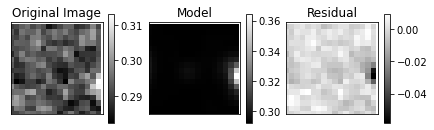

In [15]:
#test this out on one object
calc_instrflux(paramlist[1][1], paramlist[1][2], paramlist[1][3], paramlist[1][4], paramlist[1][5], paramlist[1][6])

#same thing, different syntax
#calc_instrflux(*paramlist[0][1:]) 

In [16]:
#wrapper to measure the photometry on a single object, single band
def calculate_flux(args):
    """Calculate flux."""
    f = calc_instrflux
    val = f(*args[1:])
    return(args[0], val)

In [17]:
%%time
#Here is where the multiprocessing work gets done
t2 = time.time()
outputs = []
with concurrent.futures.ProcessPoolExecutor(24) as executor:
    for result in executor.map(calculate_flux, paramlist):
        # print(result)
        df.loc[result[0],
                  'ch{:d}flux'.format(result[1][0] + 1)] = result[1][1]
        df.loc[result[0],
                  'ch{:d}flux_unc'.format(result[1][0] + 1)] = result[1][1]
        outputs.append(result)
t3 = time.time()

../code/display_images.py:10: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig=plt.figure(figsize=(7,2))
../code/display_images.py:10: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig=plt.figure(figsize=(7,2))
../code/display_images.py:10: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig=plt.figure(figsize=(7,2))
../code

CPU times: user 4.41 s, sys: 990 ms, total: 5.4 s
Wall time: 26.4 s


In [18]:
#print('Serial calculation took {:.2f} seconds'.format((t1 - t0)))
print('Parallel calculation took {:.2f} seconds'.format((t3 - t2)))
#print('Speedup is {:.2f}'.format((t1 - t0) / (t3 - t2)))

#speedup was factors of 10 - 12 for 400 - 10000 sources

Parallel calculation took 26.40 seconds


In [20]:
#Count the number of non-zero ch1 fluxes
#print('Serial calculation: number of ch1 fluxes filled in =',
#      np.sum(df.ch1flux > 0))
print('Parallel calculation: number of ch1 fluxes filled in =',
      np.sum(df.ch1flux > 0),"\n",
     'number of ch2 fluxes filled in =',
      np.sum(df.ch2flux > 0),"\n",
     'number of ch3 fluxes filled in =',
      np.sum(df.ch3flux > 0),"\n",
     'number of ch4 fluxes filled in =',
      np.sum(df.ch4flux > 0),"\n",
     'number of ch5 fluxes filled in =',
      np.sum(df.ch5flux > 0),"\n",
     'number of ch6 fluxes filled in =',
      np.sum(df.ch6flux > 0))

Parallel calculation: number of ch1 fluxes filled in = 0 
 number of ch2 fluxes filled in = 0 
 number of ch3 fluxes filled in = 0 
 number of ch4 fluxes filled in = 0 
 number of ch5 fluxes filled in = 0 
 number of ch6 fluxes filled in = 0


In [ ]:
#had to call the galex flux columns ch5 and ch6
#fix that by renaming them now
df.rename(columns={'ch5flux':'nuvflux', 'ch5flux_unc':'nuvflux_unc','ch6flux':'fuvflux', 'ch6flux_unc':'fuvflux_unc'}, inplace = True)
#pl_df.rename(columns={'ch5flux':'nuvflux', 'ch5flux_unc':'nuvflux_unc','ch6flux':'fuvflux', 'ch6flux_unc':'fuvflux_unc'}, inplace = True)

In [ ]:
df

### Plotting to confirm photometry results against COSMOS 2015 catalog

In [ ]:
%%time
#plot tractor fluxes vs. catalog splash fluxes
#should see a straightline with a slope of 1
#using sns regplot which plots both the data and a linear regression model fit
#this plotting tool is for visualization and not statistics, so I don't have rigorous slopes from it.

#setup to plot
fig, ((ax1, ax2), (ax3, ax4),(ax5, ax6)) = plt.subplots(3, 2)
fluxmax = 200
ymax = 100
xmax = 100
#ch1 
#first shrink the dataframe to only those rows where I have tractor photometry 
df_tractor = df[(df.splash_1_flux> 0) & (df.splash_1_flux < fluxmax)] #200
#sns.regplot(data = df_tractor, x = "splash_1_flux", y = "ch1flux", ax = ax1, robust = True)
sns.scatterplot(data = df_tractor, x = "splash_1_flux", y = "ch1flux", ax = ax1)

#add a diagonal line with y = x
lims = [
    np.min([ax1.get_xlim(), ax1.get_ylim()]),  # min of both axes
    np.max([ax1.get_xlim(), ax1.get_ylim()]),  # max of both axes
]

# now plot both limits against eachother
ax1.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
ax1.set(xlabel = 'COSMOS 2015 flux ($\mu$Jy)', ylabel = 'tractor flux ($\mu$Jy)', title = 'IRAC 3.6')
ax1.set_ylim([0, ymax])
ax1.set_xlim([0, xmax])


#ch2 
#first shrink the dataframe to only those rows where I have tractor photometry 
df_tractor = df[(df.splash_2_flux> 0) & (df.splash_2_flux < fluxmax)]
#sns.regplot(data = df_tractor, x = "splash_2_flux", y = "ch2flux", ax = ax2, robust = True)
sns.scatterplot(data = df_tractor, x = "splash_2_flux", y = "ch2flux", ax = ax2)

#add a diagonal line with y = x
lims = [
    np.min([ax2.get_xlim(), ax2.get_ylim()]),  # min of both axes
    np.max([ax2.get_xlim(), ax2.get_ylim()]),  # max of both axes
]

# now plot both limits against eachother
ax2.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
ax2.set(xlabel = 'COSMOS 2015 flux ($\mu$Jy)', ylabel = 'tractor flux ($\mu$Jy)', title = 'IRAC 4.5')
ax2.set_ylim([0, ymax])
ax2.set_xlim([0, xmax])


#ch3 
#first shrink the dataframe to only those rows where I have tractor photometry
df_tractor = df[(df.splash_3_flux> 0) & (df.splash_3_flux < fluxmax)]

#sns.regplot(data = df_tractor, x = "splash_3_flux", y = "ch3flux", ax = ax3, robust = True)
sns.scatterplot(data = df_tractor, x = "splash_3_flux", y = "ch3flux", ax = ax3)

#add a diagonal line with y = x
lims = [
    np.min([ax3.get_xlim(), ax3.get_ylim()]),  # min of both axes
    np.max([ax3.get_xlim(), ax3.get_ylim()]),  # max of both axes
]

# now plot both limits against eachother
ax3.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
ax3.set(xlabel = 'COSMOS 2015 flux ($\mu$Jy)', ylabel = 'tractor flux ($\mu$Jy)', title = 'IRAC 5.8')
ax3.set_ylim([0, ymax])
ax3.set_xlim([0, xmax])


#ch4 
#first shrink the dataframe to only those rows where I have tractor photometry 
df_tractor = df[(df.splash_4_flux> 0) & (df.splash_4_flux < fluxmax)]

#sns.regplot(data = df_tractor, x = "splash_4_flux", y = "ch4flux", ax = ax4, robust = True)
sns.scatterplot(data = df_tractor, x = "splash_4_flux", y = "ch4flux", ax = ax4)

#add a diagonal line with y = x
lims = [
    np.min([ax4.get_xlim(), ax4.get_ylim()]),  # min of both axes
    np.max([ax4.get_xlim(), ax4.get_ylim()]),  # max of both axes
]

# now plot both limits against eachother
ax4.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
ax4.set(xlabel = 'COSMOS 2015 flux ($\mu$Jy)', ylabel = 'tractor flux ($\mu$Jy)', title = 'IRAC 8.0')
ax4.set_ylim([0, ymax])
ax4.set_xlim([0, xmax])

#-------
#nuv 
#first shrink the dataframe to only those rows where I have tractor photometry while testing
df_tractor = df[(df.flux_galex_nuv> 0) & (df.flux_galex_nuv < 20 )]

#sns.regplot(data = df_tractor, x = "flux_galex_nuv", y = "nuvflux", ax = ax5, robust = True)
sns.scatterplot(data = df_tractor, x = "flux_galex_nuv", y = "nuvflux", ax = ax5)


#add a diagonal line with y = x
lims = [
    np.min([ax5.get_xlim(), ax5.get_ylim()]),  # min of both axes
    np.max([ax5.get_xlim(), ax5.get_ylim()]),  # max of both axes
]

# now plot both limits against eachother
ax5.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
ax5.set(xlabel = 'COSMOS 2015 flux ($\mu$Jy)', ylabel = 'tractor flux ($\mu$Jy)', title = 'Galex NUV')
ax5.set_ylim([-0.1, 0.5])
ax5.set_xlim([-0.1, 0.5])
#ax5.set_yscale('log')
#-------
#fuv 
#first shrink the dataframe to only those rows where I have tractor photometry while testing
df_tractor = df[(df.flux_galex_fuv> 0) & (df.flux_galex_fuv < 20 )]

#sns.regplot(data = df_tractor, x = "flux_galex_fuv", y = "fuvflux", ax = ax6, robust = True)
sns.scatterplot(data = df_tractor, x = "flux_galex_fuv", y = "fuvflux", ax = ax6)


#add a diagonal line with y = x
lims = [
   np.min([ax6.get_xlim(), ax6.get_ylim()]),  # min of both axes
    np.max([ax6.get_xlim(), ax6.get_ylim()]),  # max of both axes
]

# now plot both limits against eachother
ax6.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
ax6.set(xlabel = 'COSMOS 2015 flux ($\mu$Jy)', ylabel = 'tractor flux ($\mu$Jy)', title = 'Galex FUV')
#ax6.set_yscale('log')
ax6.set_ylim([-0.1, 0.3])
ax6.set_xlim([-0.1, 0.3])


plt.tight_layout()

fig.subplots_adjust( hspace=0.5)
fig.set_size_inches(8, 12)

#plt.savefig('flux_comparison.png')

Tractor is working for IRAC; Comparison of tractor derived fluxes with COSMOS 2015 fluxes for all four Spitzer IRAC channels.  Blue points represent each object from the subset of the COSMOS 2015 catalog.  The blue line is a linear regression robust fit to the data with uncertainties shown as the light blue wedge.  The black line is a y = x line plotted to guide the eye.

In [ ]:
#save the dataframe with the forced photometry
#df.to_pickle('../data/COSMOS_15arcmin.pkl')

#or read it back in
#df = pd.read_pickle('../data/COSMOS_15arcmin_FUV.pkl')

## Cross match this newly built catalog with an X-ray catalog
We are using nway as the tool to do the cross match Salvato et al. 2017.
nway expects input as two fits table files and outputs a third table file with all the possible matches and their probabilities of being the correct match.  We then sort that catalog and take only the best matches to be the true matches.

In [ ]:
#first get an X-ray catalog from Heasarc
heasarc = Heasarc()
table = heasarc.query_mission_list()
mask = (table['Mission'] =="CHANDRA")
chandratable = table[mask]  

#tell me which tables exist there
#chandratable.pprint(max_lines = 200, max_width = 130)

#want ccosmoscat
mission = 'ccosmoscat'
#coords already defined above where I pull the original COSMOS catalog
ccosmoscat_rad = 1 #radius of chandra cosmos catalog
ccosmoscat = heasarc.query_region(coords, mission=mission, radius='1 degree', resultmax = 5000, fields = "ALL")


In [ ]:
#astropy doesn't recognize capitalized units
#so there will be some warnings here on writing out the file, but we can safely ignore those

#need to make the chandra catalog into a fits table 
#and needs to include area of the survey.
ccosmoscat.meta['NAME'] = 'CHANDRA'
ccosmoscat.meta['SKYAREA'] = float(1.0)  #in square degrees

#also need an 'ID' column
ccosmoscat['ID'] = range(1, len(ccosmoscat) + 1)
ccosmoscat.write('../data/Chandra/COSMOS_chandra.fits', overwrite = "True")

#above isn't working to get the name into the table
#try this
nway_write_header('../data/Chandra/COSMOS_chandra.fits', 'CHANDRA', float(ccosmoscat_rad**2) )



In [ ]:
#also need to transform the main pandas dataframe into fits table for nway

#make an index column for tracking later
df['ID'] = range(1, len(df) + 1)

#need this to be a fits table and needs to include area of the survey.
df_table = Table.from_pandas(df)
df_table
df_table.meta['NAME'] = 'OPT'
df_table.meta['SKYAREA'] = float((2*rad_in_arcmin/60)**2) # catalog

df_table.write('../data/multiband_phot.fits', overwrite = "True")

#above isn't working to get the name into the table
#try this
nway_write_header('../data/multiband_phot.fits', 'OPT', float((2*rad_in_arcmin/60)**2) )


In [ ]:
#nway calling sequence
!nway.py '../data/Chandra/COSMOS_chandra.fits' :ERROR_RADIUS '../data/multiband_phot.fits' 0.1 --out=../data/Chandra/chandra_multiband.fits --radius 15 --prior-completeness 0.9

In [ ]:
#Clean up the cross match results and merge them back into main pandas dataframe

#read in the nway matched catalog
xmatch = Table.read('../data/Chandra/chandra_multiband.fits', hdu = 1)
df_xmatch = xmatch.to_pandas()

#manual suggests that p_i should be greater than 0.1 for a pure catalog.
#ok, so the matched catalog has multiple optical associations for some of the XMM detections.
#simplest thing to do is only keep match_flag = 1
matched = df_xmatch.loc[(df_xmatch['p_i']>=0.1) & df_xmatch['match_flag']==1]

#merge this info back into the df_optical dataframe.
merged = pd.merge(df, matched, 'outer',left_on='ID', right_on = 'OPT_ID')

#will need to delete unnecessary rows that matched has duplicated from pl_df
#for col in merged.columns:
#    print(col)

#remove all the rows which start with "OPT" because they are duplications of the original catalog
merged = merged.loc[:, ~merged.columns.str.startswith('OPT')]

#somehow the matching is giving negative fluxes in the band where there is no detection 
#if there is a detection in the other band
#clean that up to make those negative fluxes = 0

merged.loc[merged['flux_chandra_2_10'] < 0, 'flux_chandra_2_10'] = 0
merged.loc[merged['flux_chandra_05_2'] < 0, 'flux_chandra_05_2'] = 0


In [ ]:
#How many CHandra sources are there?

#make a new column which is a bool of existing chandra measurements
merged['chandra_detect'] = 0
merged.loc[merged.CHANDRA_FLUX > 0,'chandra_detect']=1

#make one for Galex too
merged['galex_detect'] = 0
merged.loc[merged.flux_galex_nuv > 0,'galex_detect']=1


print('number of Chandra detections =',np.sum(merged.chandra_detect > 0))
print('number of Galex detections =',np.sum(merged.galex_detect > 0))

### Plotting to confirm photometry results against COSMOS 2015 catalog

In [ ]:
#Plot 
fig, (ax1,ax2) = plt.subplots(1,2)
#first shrink the dataframe to only those rows where I have tractor photometry while testing
merged_small = merged[(merged.chandra_detect >= 0) ] 

sns.scatterplot(data = merged_small, x = "CHANDRA_HB_FLUX", y = "flux_chandra_2_10", ax = ax2)#, robust = True)#scatterplot
#add a diagonal line with y = x
lims = [
    np.min([ax2.get_xlim(), ax2.get_ylim()]),  # min of both axes
    np.max([ax2.get_xlim(), ax2.get_ylim()]),  # max of both axes
]

# now plot both limits against eachother
ax2.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
ax2.set(xlabel = 'COSMOS (erg/s/cm2)', ylabel = 'nway matched (erg/s/cm2)', title = 'Chandra HB (2 - 10)')


sns.scatterplot(data = merged_small, x = "CHANDRA_SB_FLUX", y = "flux_chandra_05_2", ax = ax1)#, robust = True)#scatterplot
#add a diagonal line with y = x
lims = [
    np.min([ax1.get_xlim(), ax1.get_ylim()]),  # min of both axes
    np.max([ax1.get_xlim(), ax1.get_ylim()]),  # max of both axes
]

# now plot both limits against eachother
ax1.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
ax1.set(xlabel = 'COSMOS (erg/s/cm2)', ylabel = 'nway matched(erg/s/cm2)', title = 'Chandra SB (05 - 2)')




## Make some plots which show off the results and facilitate science

In [ ]:
#IRAC color color plots akin to Lacy et al. 2004
#overplot galex sources
#overplot xray sources

#first select on 24 micron 
merged_24 = merged[(merged.flux_24 >= 0) ] 

#negative Galex fluxes are causing problems
merged_24.loc[merged_24.fuvflux < 0, 'fuvflux'] = 0
merged_24.loc[merged_24.nuvflux < 0, 'nuvflux'] = 0


fig, ax = plt.subplots()
merged_24['F5.8divF3.6'] = merged_24.ch3flux / merged_24.ch1flux
merged_24['F8.0divF4.5'] = merged_24.ch4flux / merged_24.ch2flux

merged_allirac = merged_24[(merged_24['F8.0divF4.5'] > 0) & (merged_24['F5.8divF3.6'] > 0)]

#plot all the points
sns.scatterplot(data = merged_allirac, x = 'F5.8divF3.6', y = 'F8.0divF4.5',
                 ax = ax, alpha = 0.5)

#plot only those points with Galex detections
galex_detect = merged_allirac[merged_allirac.galex_detect > 0]
sns.scatterplot(data = galex_detect, x = 'F5.8divF3.6', y = 'F8.0divF4.5',
                 ax = ax, alpha = 0.5)

#plot only those points with chandra detections
chandra_detect = merged_allirac[merged_allirac.chandra_detect > 0]
sns.scatterplot(data = chandra_detect, x = 'F5.8divF3.6', y = 'F8.0divF4.5',
                 ax = ax)



ax.set(xscale="log", yscale="log")
ax.set_ylim([0.1, 10])
ax.set_xlim([0.1, 10])

ax.set(xlabel = 'log F5.8/F3.6', ylabel = 'log F8.0/F4.5')
plt.legend([],[], frameon=False)

#apparently there is a known bug in mpld3 that it doesn't work with log scaled plots
#mpld3.display(fig)  


In [ ]:
#UV IR color color plot akin to Bouquin et al. 2015
fig, ax = plt.subplots()
merged['FUV-NUV'] = merged.mag_galex_fuv - merged.mag_galex_nuv
merged['NUV-3.6'] = merged.mag_galex_nuv - merged.splash_1_mag


#plot all the points
#sns.scatterplot(data = merged, x = 'NUV-3.6', y = 'FUV-NUV',
#                 ax = ax, alpha = 0.5)

#plot only those points with Galex detections
galex_detect = merged[merged.galex_detect > 0]
sns.kdeplot(data = galex_detect, x = 'NUV-3.6', y = 'FUV-NUV',
                 ax = ax, fill = True, levels = 15)#scatterplot , alpha = 0.5

#plot only those points with chandra detections
#now with color coding Chandra sources by hardness ratio a la Moutard et al. 2020
chandra_detect = merged[merged.chandra_detect > 0]
sns.scatterplot(data = chandra_detect, x = 'NUV-3.6', y = 'FUV-NUV',
                 ax = ax, hue= 'CHANDRA_HARDNESS_RATIO',palette="flare")

#whew that legend for the hue is terrible
#try making it into a colorbar outside the plot instead
norm = plt.Normalize(merged['CHANDRA_HARDNESS_RATIO'].min(), merged['CHANDRA_HARDNESS_RATIO'].max())
sm = plt.cm.ScalarMappable(cmap="flare", norm=norm)
sm.set_array([])

# Remove the legend and add a colorbar
ax.get_legend().remove()
ax.figure.colorbar(sm)

#ax.set(xscale="log", yscale="log")
ax.set_ylim([-0.5, 3.5])
ax.set_xlim([-1, 7])

ax.set(xlabel = 'NUV - [3.6]', ylabel = 'FUV - NUV')
#plt.legend([],[], frameon=False)

#fig.savefig("../data/color_color.png")
mpld3.display(fig)  


We extend the works of Bouquin et al. 2015 and Moutard et al. 2020 by showing a GALEX - Spitzer color color diagram over plotted with Chandra detections.  Blue galaxies in these colors are generated by O and B stars and so must currently be forming stars. We find a tight blue cloud in this color space identifying those star forming galaxies.  Galaxies off of the blue cloud have had their star formation quenched, quite possibly by the existence of an AGN through removal of the gas reservoir required for star formation.  Chandra detected galaxies host AGN, and while those are more limited in number, can be shown here to be a hosted by all kinds of galaxies, including quiescent galaxies which would be in the upper right of this plot.  This likely implies that AGN are indeed involved in quenching star formation.  Additionally, we show the Chandra hardness ratio (HR) color coded according to the vertical color bar on the right side of the plot.  HR is defined as (H-S)/ (H+S) where H and S are the hard[2-10KeV] and soft[0.5-2KeV] bands of Chandra.  Those AGN with higher hardness ratios have their soft x-ray bands heavily obscured and appear to reside preferentially toward the quiescent galaxies.

In [ ]:
#potential plot ideas
#salim et al. 2014 serbia astronomical journal
#(3.6 magniutde) vs. (NUV - 3.6)


#match to cosmos catalog
#get the galex fluxes then make the green valley plots of bouquin et al, 
#then overplot x-ray 

#second option
#match to cosmos for 24 microns and make lacy et al. plot


In [ ]:
for col in merged.columns:
    print(col)